# simulate signals

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error # MSE

In [2]:
#generate 9000 points in [0,9]
t = np.linspace(0, 9, 9000)

In [3]:
#generate the pure signal
x_volts = 0.5*t + np.sin(np.pi*t) + np.sin(2*np.pi*t) +  np.sin(6*np.pi*t)

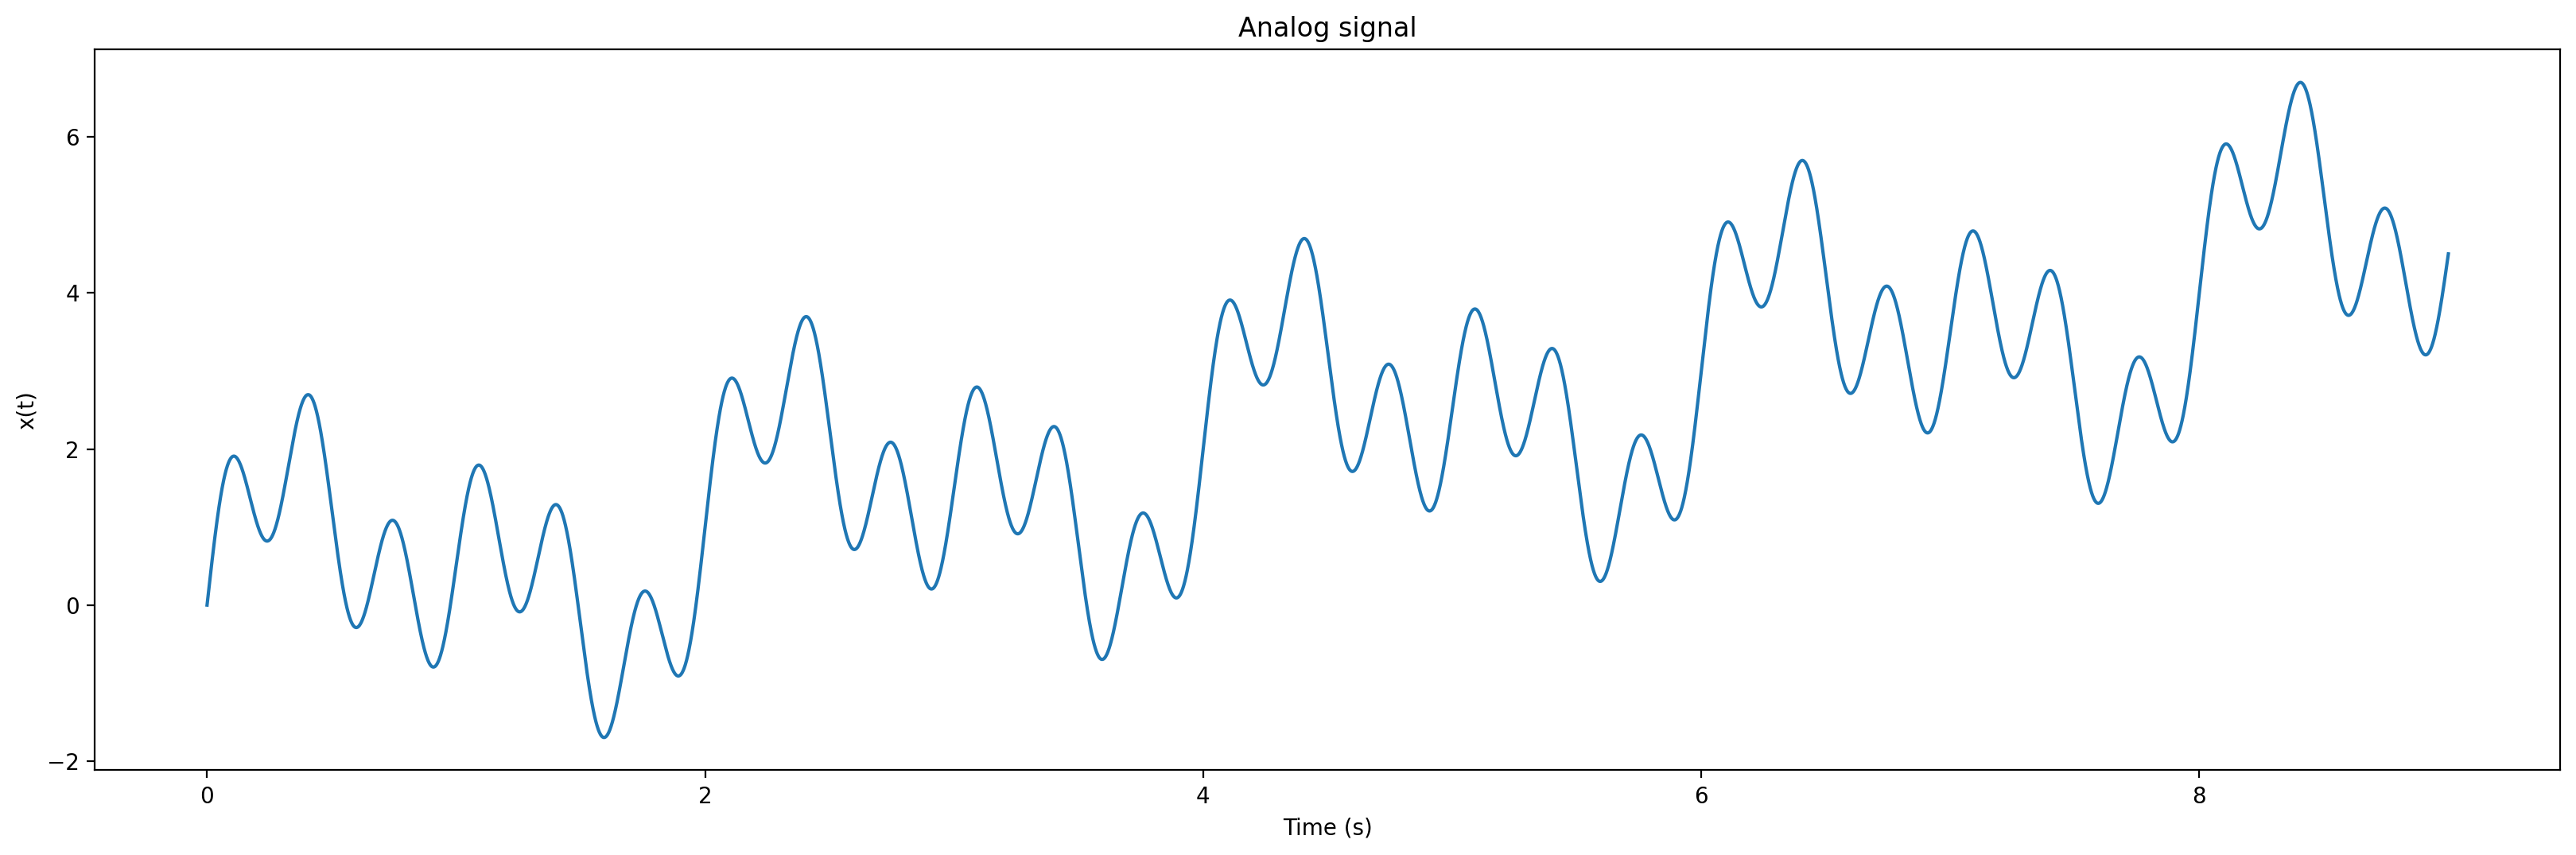

In [4]:
#plot pure signal
plt.figure(figsize=(20,6),dpi=200)
plt.plot(t, x_volts)
plt.title('Analog signal')
plt.ylabel('x(t)')
plt.xlabel('Time (s)')
plt.savefig("./Analog signal.jpg")
plt.show()

# add noise

In [5]:
from PyEMD import EMD,EEMD,CEEMDAN,Visualisation
from PyEMD.checks import whitenoise_check
import pandas as pd

In [98]:
#add white noise into pure signals and plot the contaminated signals 
def add_noise(signal,target,show = False):
    np.random.seed(10)
    x_watts = signal ** 2
   # Adding noise using target SNR
   # Set a target SNR
    target_snr_db = target
    t = np.linspace(0, 9, 9000)
    # Calculate signal power and convert to dB 
    sig_avg_watts = np.mean(x_watts)
    sig_avg_db = 10 * np.log10(sig_avg_watts)
    # Calculate noise according to [2] then convert to watts
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    # Generate an sample of white noise
    mean_noise = 0
    noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
    # Noise up the original signal
    y_volts = x_volts + noise_volts

    if show:
        # Plot signal with noise
        plt.figure(figsize=(20,6),dpi=200)
        plt.plot(t, y_volts)
        plt.title('Analog signal with '+ str(target)+ 'dB noise')
        plt.ylabel('x(t)')
        plt.xlabel('Time (s)')
        plt.savefig("./Analog signal with noise"+str(target)+" .jpg")
        plt.show()
    
    return y_volts

In [15]:
#use emd or ceemdan to decompose data and remove white noise
def emd_denoise(data,mode):
    if mode == 'emd':
        decom = EMD()
    if mode == 'eemd':
        decom = EEMD()
    if mode == 'ceemdan':
        decom = CEEMDAN()
    imfs = decom(data)
    imf_num = imfs.shape[0]
    significant_imfs = whitenoise_check(imfs)
    denoised_data = np.array([0]*len(data))
    #print(significant_imfs)
    for i in significant_imfs:
        if significant_imfs[i] ==1:
            denoised_data = denoised_data+imfs[i-1]
    return denoised_data,imf_num

In [16]:
#calculate the signal-noise-ratio
def calculate_snr(signal,nsiganl):
    R = np.array(siganl)**2
    N1 = nsiganl - signal
    N1_square = np.array(N1)**2
    snr = 10 * np.log10(sum(R)/sum(N1_square))
    return snr

# plot 4 noisy signals

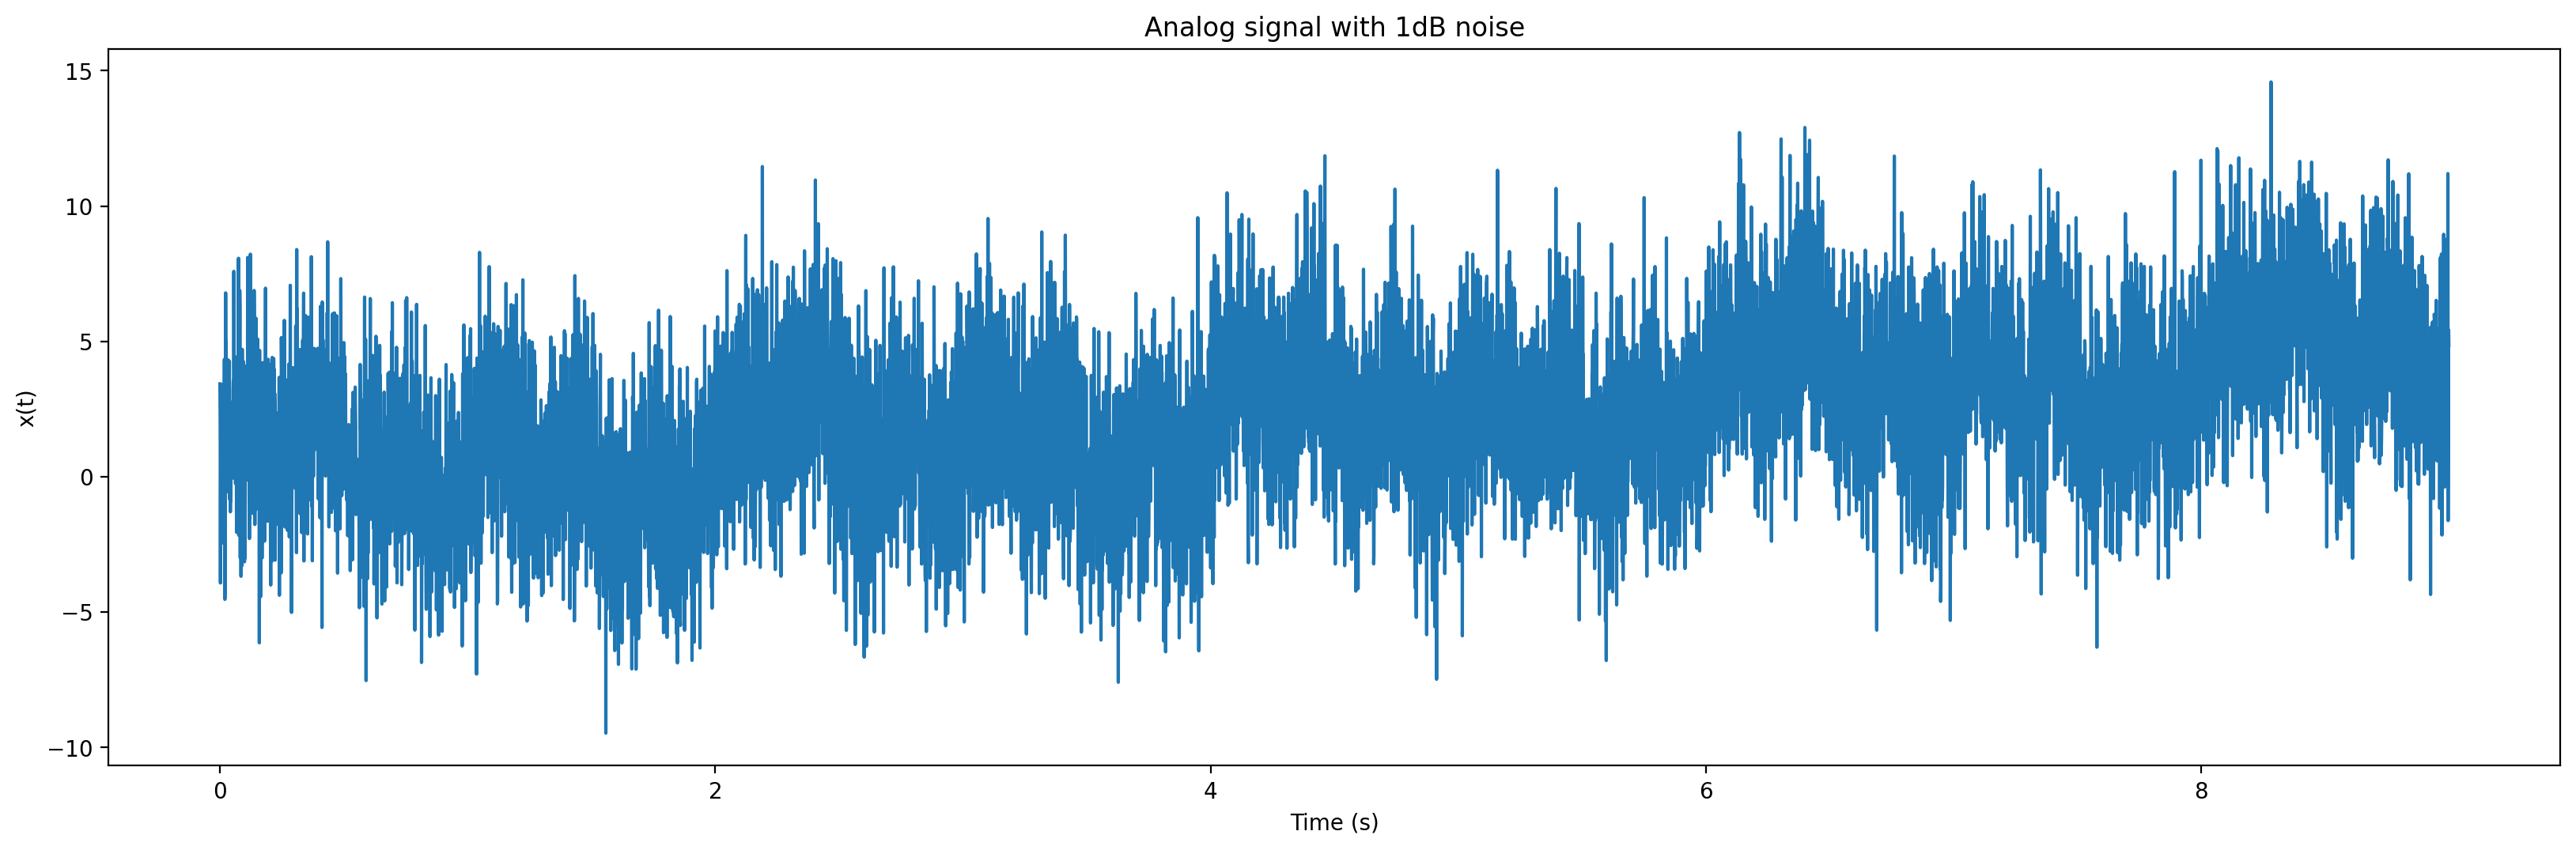

In [99]:
#example contaminated signals with SNR of 1 dB
noisy = add_noise(x_volts,1,show = True)

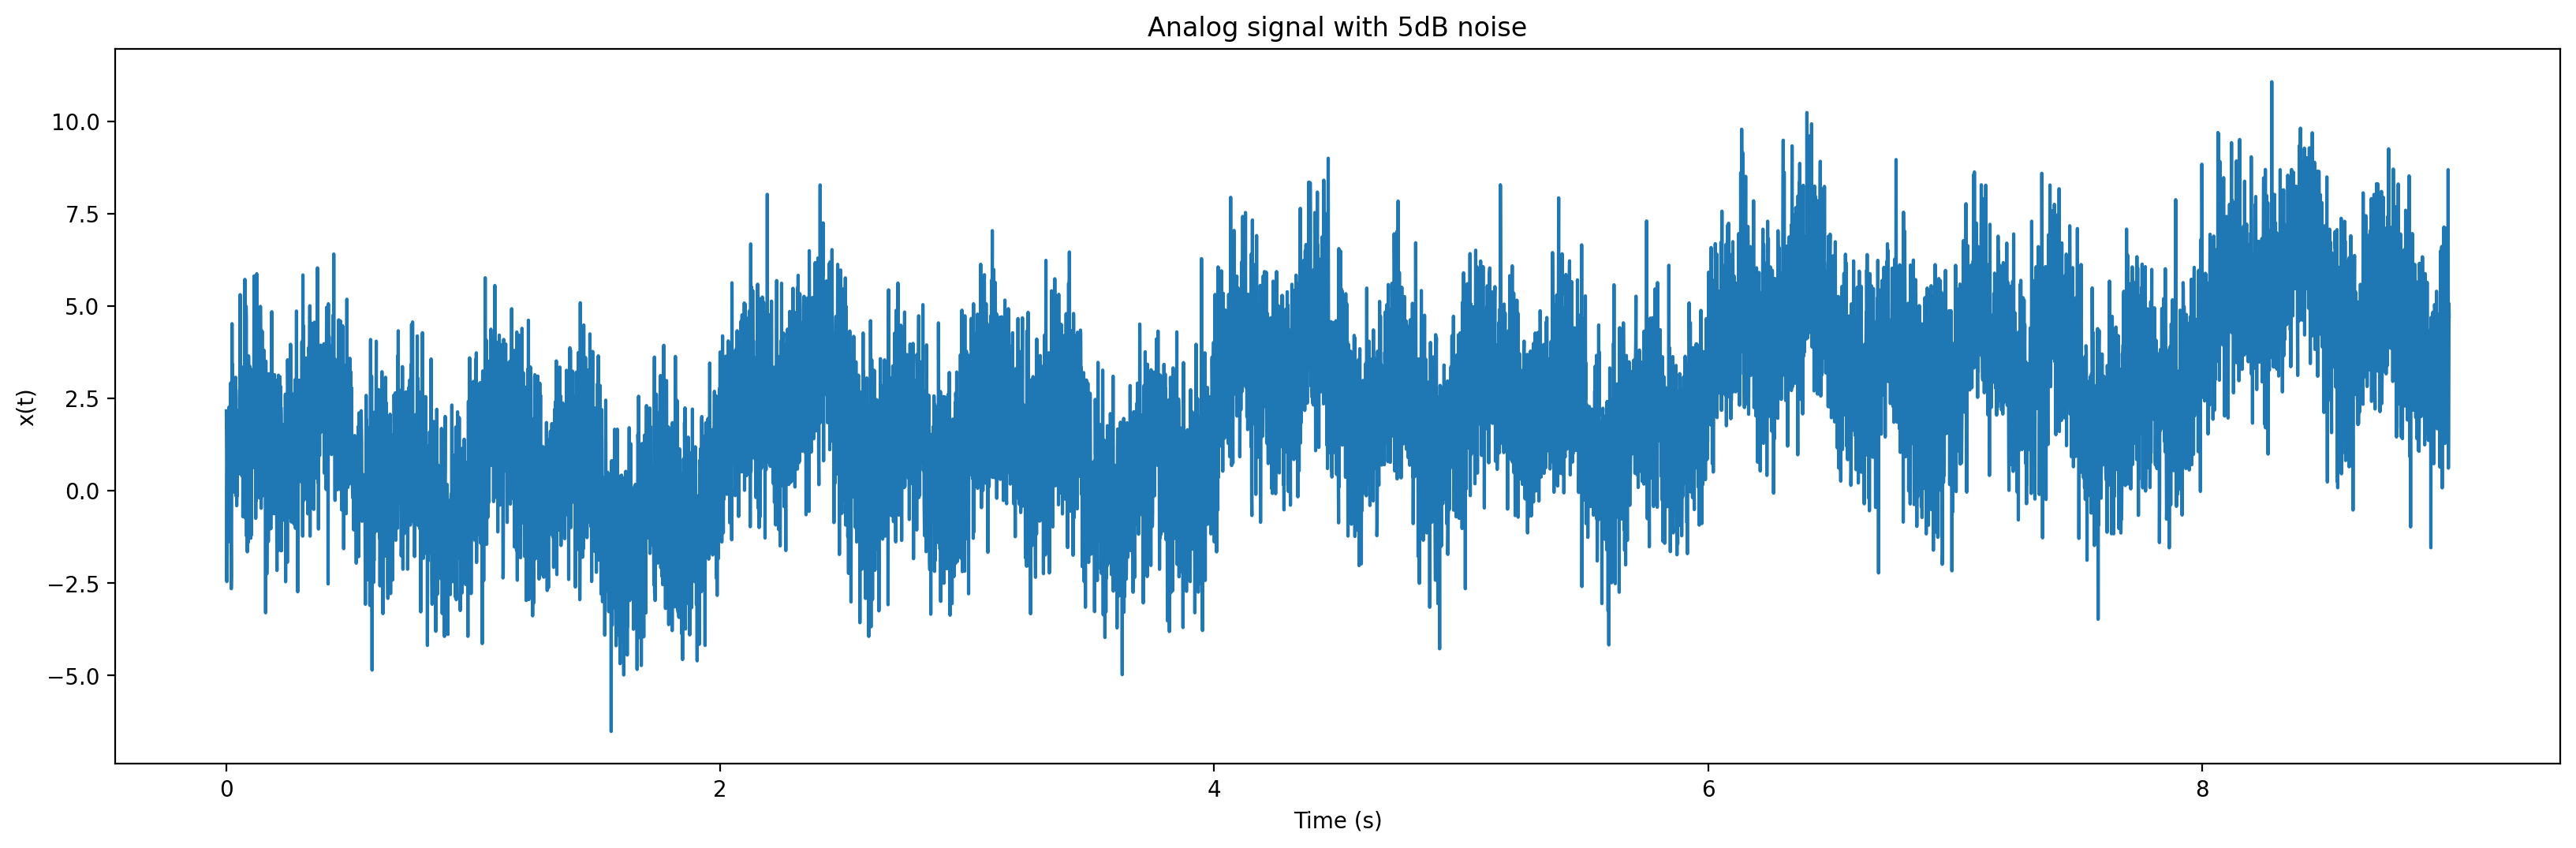

In [18]:
#example contaminated signals with SNR of 5 dB
noisy = add_noise(x_volts,5,show = True)

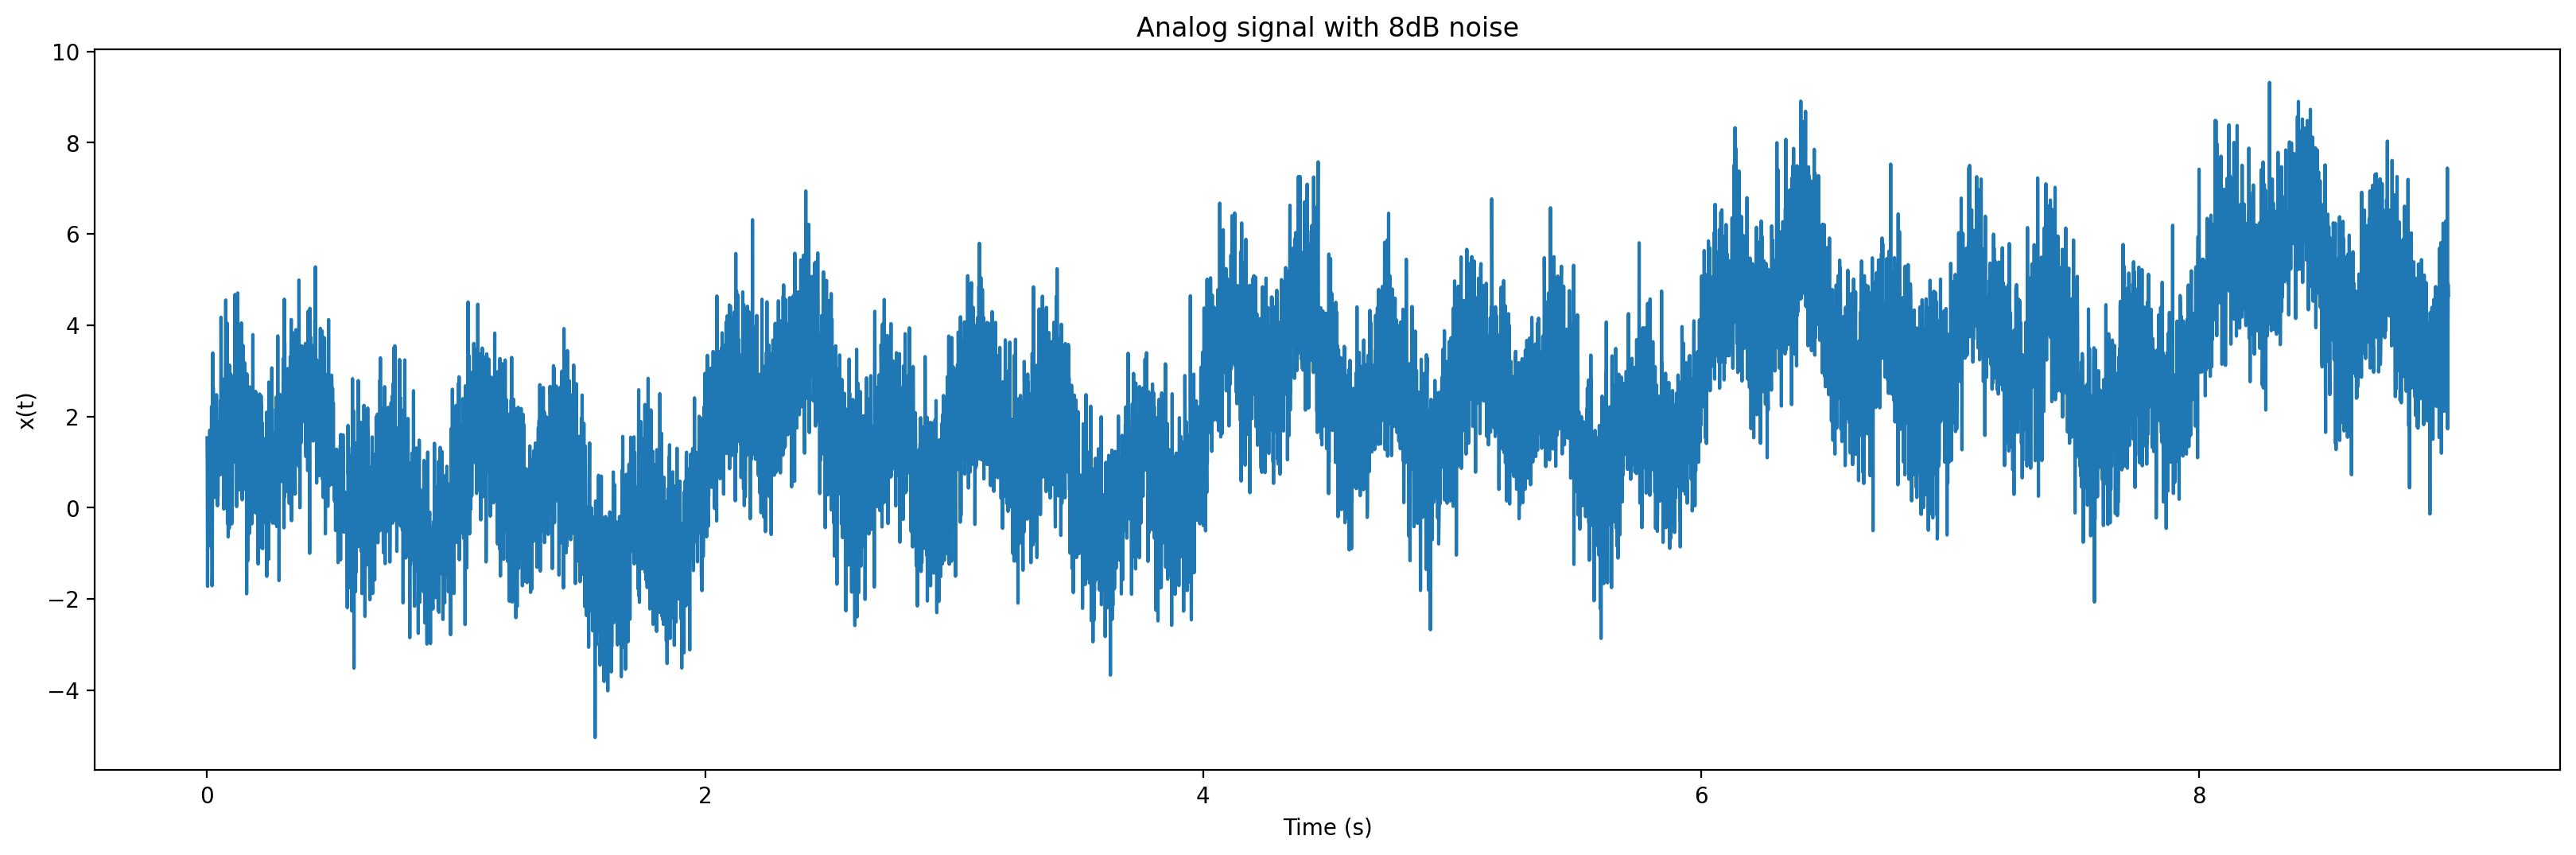

In [19]:
#example contaminated signals with SNR of 8 dB
noisy = add_noise(x_volts,8,show = True)

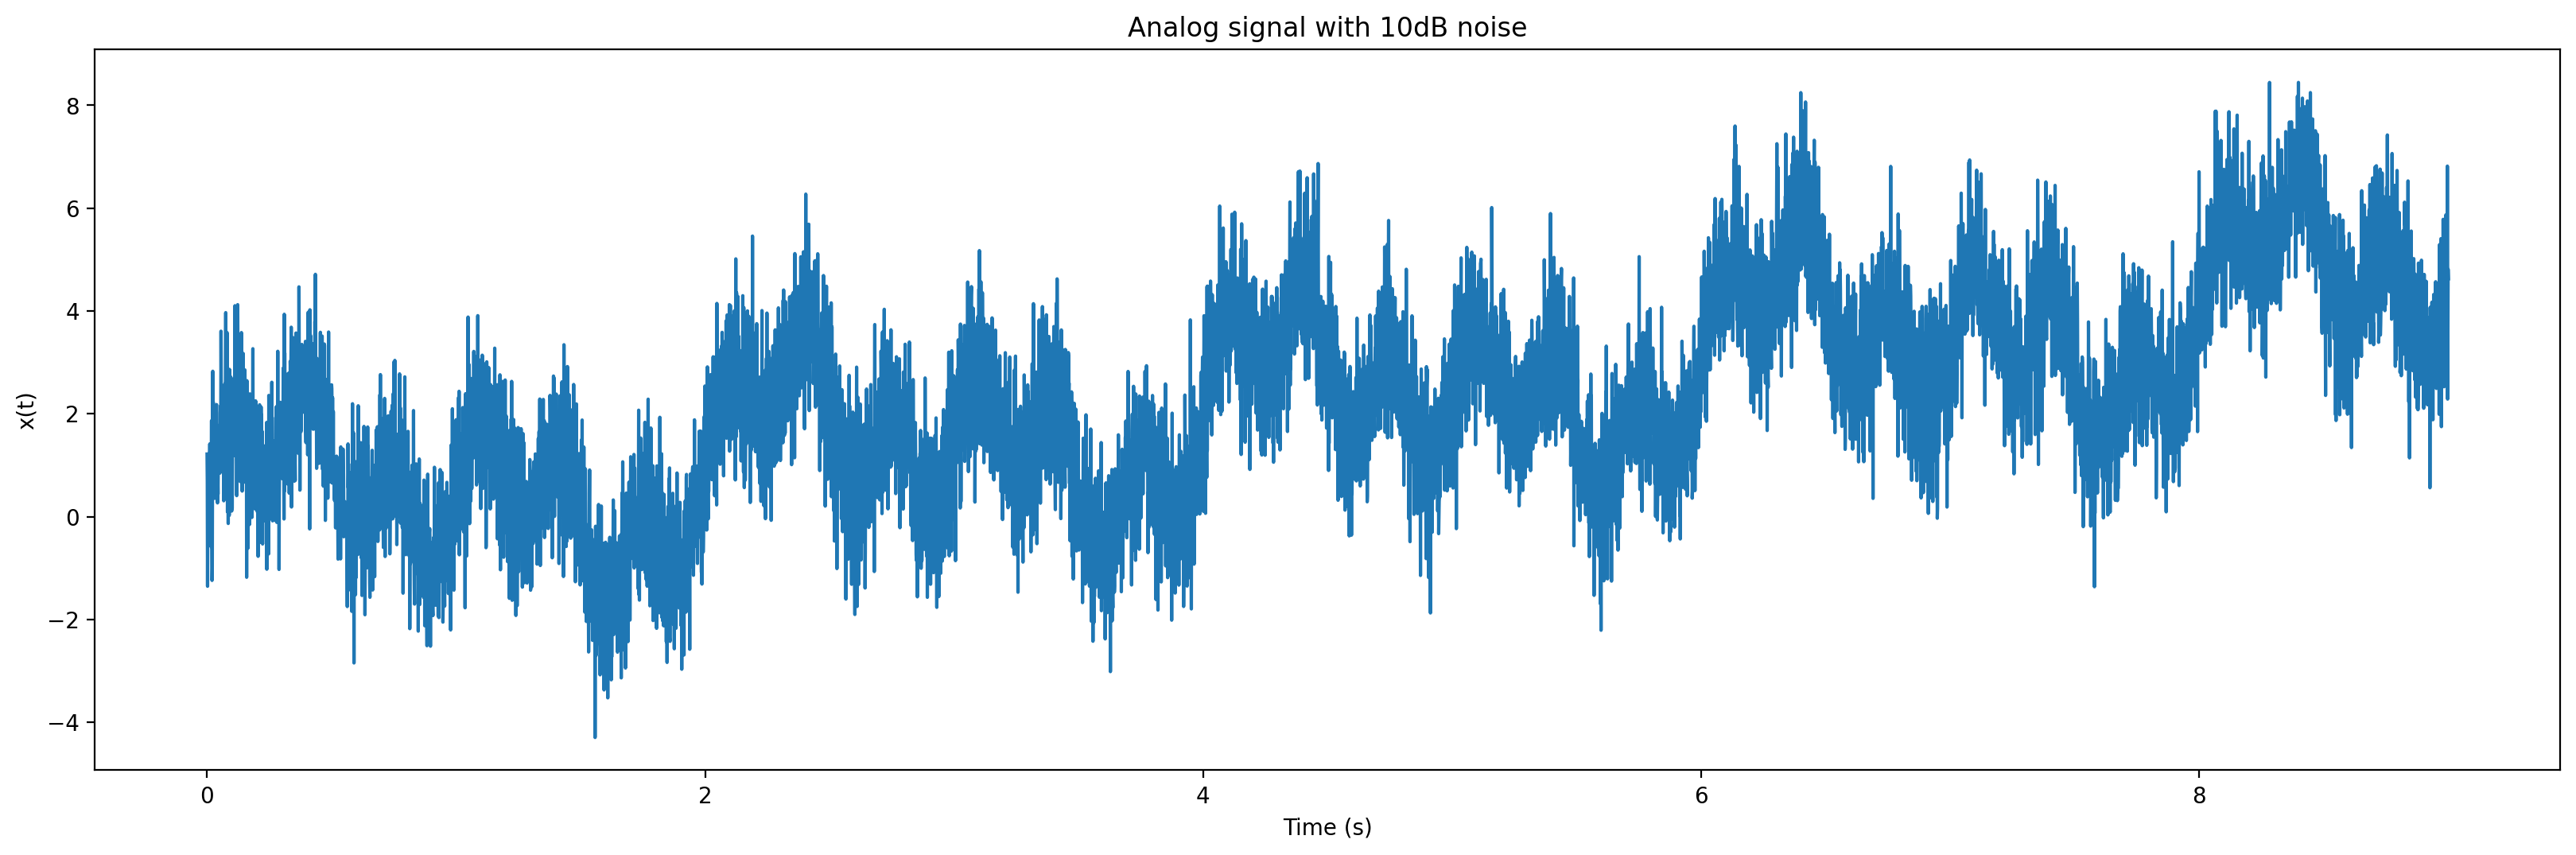

In [20]:
#example contaminated signals with SNR of 10 dB
noisy = add_noise(x_volts,10,show = True)

# plot 5 lines with different noise

# emd

In [92]:
#use EMD to decompose signals and remove noise and reconstrcut signals
lst = [1,5,8,10]
emd_snr_list = []
emd_mse_list = []
emd_nsignal = []
emd_num = []
for i in lst:
    noisy = add_noise(x_volts,i,show = False)
    nsiganl,n = emd_denoise(noisy,'emd')
    #store denosed data
    emd_nsignal.append(nsiganl)
    emd_num.append(n)
    snr = calculate_snr(x_volts,nsiganl)
    mse = mean_squared_error(x_volts, nsiganl, squared=True)
    emd_snr_list.append(snr)
    emd_mse_list.append(mse)

In [93]:
#calculate the SNR of denoised data
emd_snr_list

[18.124291708887966, 21.68677746427807, 24.788558799121283, 24.338655057229005]

In [94]:
#calculate the MSE of denoised data
emd_mse_list

[0.13428759197749318,
 0.057852547107102484,
 0.028196065263193588,
 0.03128872187494325]

## ceemdan

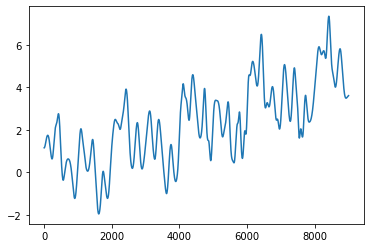

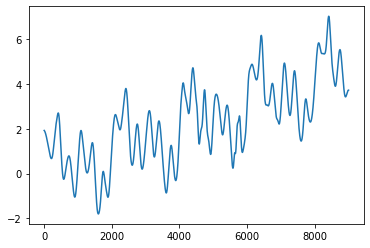

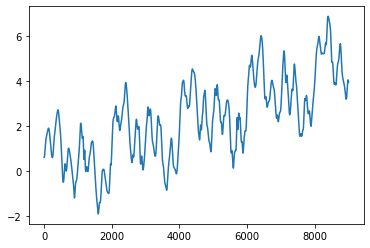

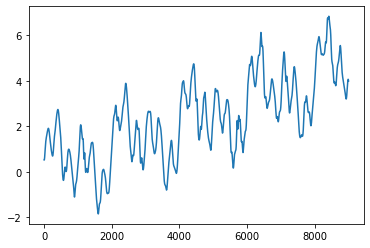

In [27]:
#use CEEMDAN to decompose signals and remove noise and reconstrcut signals
from sklearn.metrics import mean_squared_error
ceemdan_snr_list = []
ceemdan_mse_list = []
ceemdan_nsignal = []

for i in lst:
    noisy = add_noise(x_volts,i,show = False)
    nsiganl,n = emd_denoise(noisy,'ceemdan')
    plt.plot(nsiganl)
    plt.show()
    ceemdan_nsignal.append(nsiganl)
    snr = calculate_snr(x_volts,nsiganl)
    mse = mean_squared_error(x_volts, nsiganl, squared=True)
    ceemdan_snr_list.append(snr)
    ceemdan_mse_list.append(mse)

In [28]:
#calculate the SNR of denoised data
ceemdan_snr_list

[18.127835520506753, 21.27301850116284, 22.555694404466067, 24.332549735340677]

In [29]:
#calculate the MSE of denoised data
ceemdan_mse_list

[0.134489841975397,
 0.06375540790037441,
 0.04744851015117299,
 0.03128550395997591]

## VMD + DFA

In [30]:
# VMD # There are some problems in this module
# -------------------------------
#use VMD to decompose data and plot results
def vmd_decom(series,K,draw = False):
    from vmdpy import VMD  
    # VMD parameters
    alpha = 2000       # moderate bandwidth constraint  
    tau = 0.           # noise-tolerance (no strict fidelity enforcement)  
    DC = 0             # no DC part imposed  
    init = 1           # initialize omegas uniformly  
    tol = 1e-7         

    # VMD 
    imfs_vmd, imfs_hat, omega = VMD(series, alpha, tau, K, DC, init, tol)  
    imfs_num = np.shape(imfs_vmd)[0]
    
    if draw:
        # Plot original data
        fig = plt.figure(figsize=(16,2*imfs_num))
        plt.subplot(1+imfs_num, 1, 1 )
        plt.plot(series, color='#0070C0') #F27F19 orange #0070C0 blue
        plt.ylabel('VMD Original data')
    
        # Plot IMFs
        for i in range(imfs_num):
            plt.subplot(1 + imfs_num,1,2 + i)
            plt.plot(imfs_vmd[i, :], color='#F27F19')
            plt.ylabel('VMD-IMF'+str(i))
            
        plt.show()
    
    # Save data
    imfs_df = pd.DataFrame(imfs_vmd.T)
    imfs_df.columns = ['imf'+str(i) for i in range(imfs_num)]

    return imfs_df # pd.DataFrame

In [31]:
import fathon
from fathon import fathonUtils as fu

In [32]:
#use DFA to calculate the alpha of a time series
def calculate_H(array):
    a = fu.toAggregated(array)
    pydfa = fathon.DFA(a)
    wins = fu.linRangeByStep(4,16)
    n,F = pydfa.computeFlucVec(wins)
    H,H_intercept = pydfa.fitFlucVec()
    return H

In [33]:
# plot alphas
def plot_dfa(H_list):
    plt.plot(H_list)
    plt.axhline(0.75,color = 'red')
    plt.xlabel('IMF')
    plt.show()

In [34]:
#use the alpha of the original time series to set J
def J_number(num):
    if num <= 0.75:
        J = 1
    elif num> 0.75 and num <= 1.0:
        J = 2
    elif num > 1 and num <= 1.5:
        J = 3
    else:
        J = 4
    return J

In [35]:
# use J to calculate K
def K_num(series,J):
    K = 1
    num = 0
    while (num < 20):
        num = 0
        vmf_imfs = vmd_decom(series,K,draw=False)
        for i in vmf_imfs.columns:
            if calculate_H(vmf_imfs[i]) >= 0.75:
                num = num +1
        if num > J:
                return K-1
        K = K + 1
    #the Max K
    #K = K -1
    #return K

In [36]:
#apply VMD to time series and get K modes.
#reconstrcut data by suming the first J modes.
def denoise_vmd(series,K,J):
    
    imfs = vmd_decom(series,K)
    recon_data = imfs.iloc[:,:J].sum(axis = 1)
    if len(series) > len(recon_data):
        recon_data = list(recon_data)
        recon_data.insert(0,recon_data[0])
        
    return np.array(recon_data)

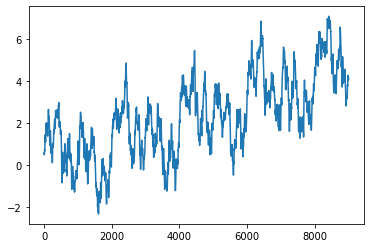

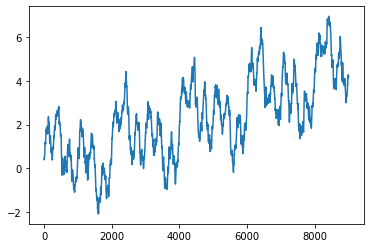

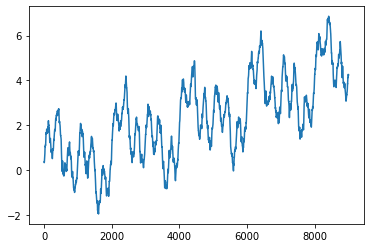

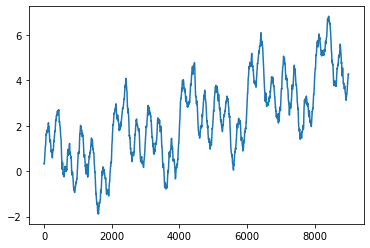

In [37]:
#use VMD-DFA to denoise data
from sklearn.metrics import mean_squared_error
vmd_snr_list = []
vmd_mse_list = []
vmd_nsignal = []
for i in lst:
    noisy = add_noise(x_volts,i,show = False)
    alpha0 = calculate_H(noisy)
    J = J_number(alpha0)
    K = K_num(noisy,J)
    #print(J,K)
    nsiganl = denoise_vmd(noisy,K,J)
    vmd_nsignal.append(nsiganl)
    plt.plot(nsiganl)
    plt.show()
    snr = calculate_snr(x_volts,nsiganl)
    mse = mean_squared_error(x_volts, nsiganl, squared=True)
    vmd_snr_list.append(snr)
    vmd_mse_list.append(mse)

In [38]:
#calculate the SNR of denoised data
vmd_snr_list

[15.892434447559289,
 19.799117435542538,
 22.754384150168818,
 24.729285332375674]

In [39]:
#calculate the MSE of denoised data
vmd_mse_list

[0.22777495229379938,
 0.09012517372524322,
 0.045123602922179526,
 0.0284930640030763]

# VMD-EMD-DFA

In [40]:
#in the mode number K in EMD is the same as that in EMD
# apply VMD with K and reconstruct signals by summing the modes, the alphas of which are larger than 0.75
def denoise_vmd_emd(series,K):
    imfs = vmd_decom(series,K)
    no = 0
    col_num = []
    for i in imfs.columns :
        if calculate_H(imfs[i]) >= 0.75:
            col_num.append(no)
        no = no+1
    
    recon_data = imfs.iloc[:,col_num].sum(axis = 1)
    
    #Add missing values by inserting the same value at the beginning
    if len(series) > len(recon_data):
        recon_data = list(recon_data)
        recon_data.insert(0,recon_data[0])
        
    return np.array(recon_data)

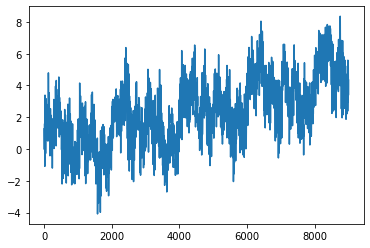

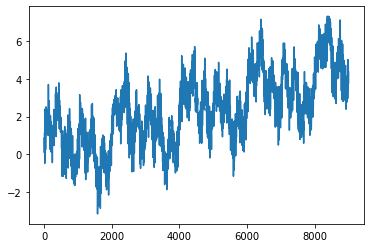

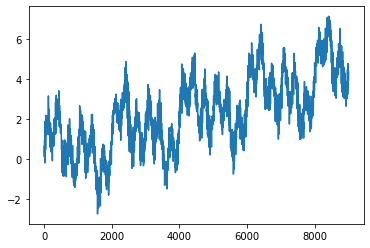

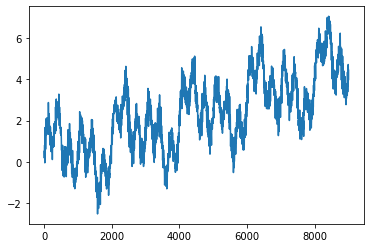

In [41]:
#use VMD-EMD-DFA to denoise signals
from sklearn.metrics import mean_squared_error
vmd_EMD_snr_list = []
vmd_EMD_mse_list = []
vmd_EMD_nsignal = []
count = 0
for i in lst:
    noisy = add_noise(x_volts,i,show = False)
   
    #print(J,K)
    nsiganl = denoise_vmd_emd(noisy,emd_num[count])
    vmd_EMD_nsignal.append(nsiganl)
    plt.plot(nsiganl)
    plt.show()
    snr = calculate_snr(x_volts,nsiganl)
    mse = mean_squared_error(x_volts, nsiganl, squared=True)
    vmd_EMD_snr_list.append(snr)
    vmd_EMD_mse_list.append(mse)
    count = count +1

In [42]:
#calculate the SNR of denoised data
vmd_EMD_mse_list

[0.9606927349383869,
 0.38230671906058344,
 0.19162598696148303,
 0.12289561727007794]

In [43]:
#calculate the MSE of denoised data
vmd_EMD_snr_list

[9.987241746583157, 13.668137246311423, 16.547692974205066, 18.42925881844745]

## plot

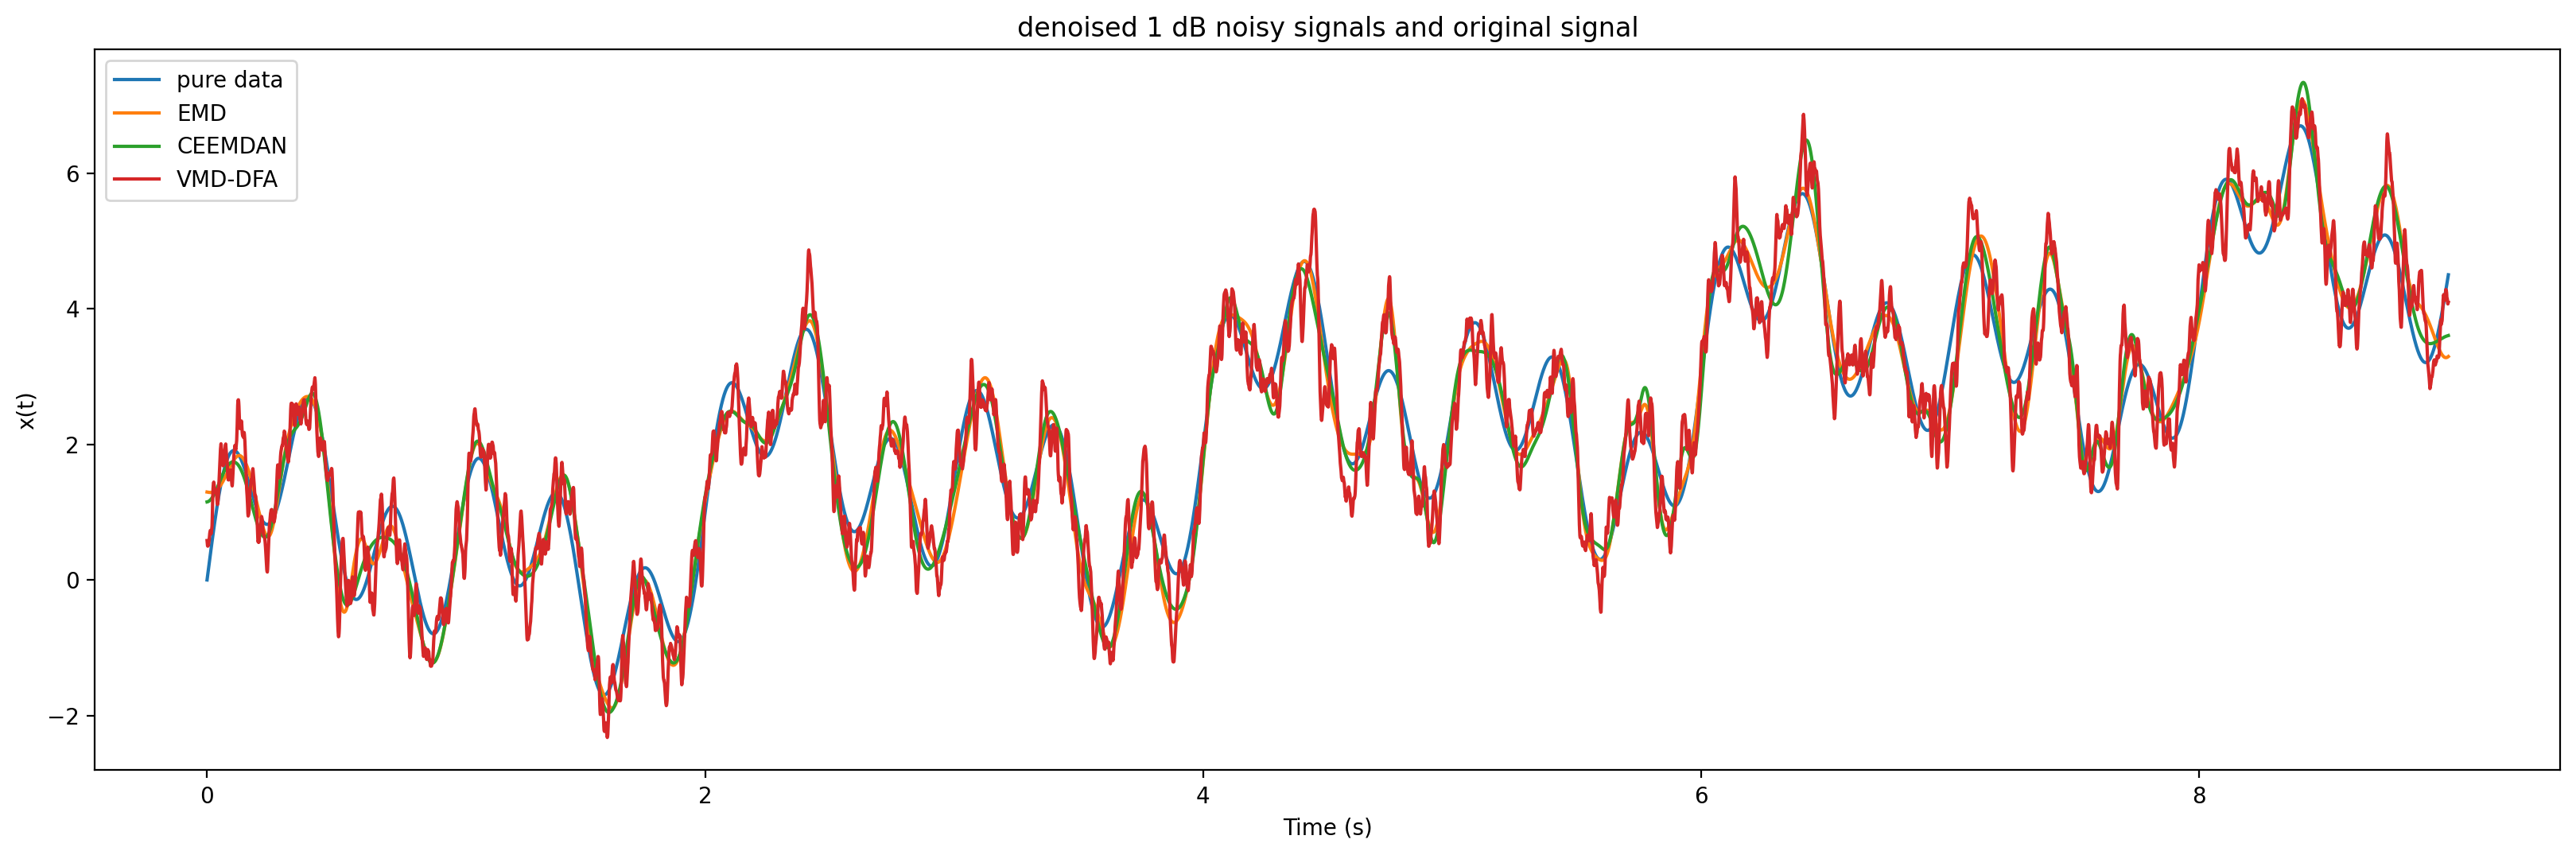

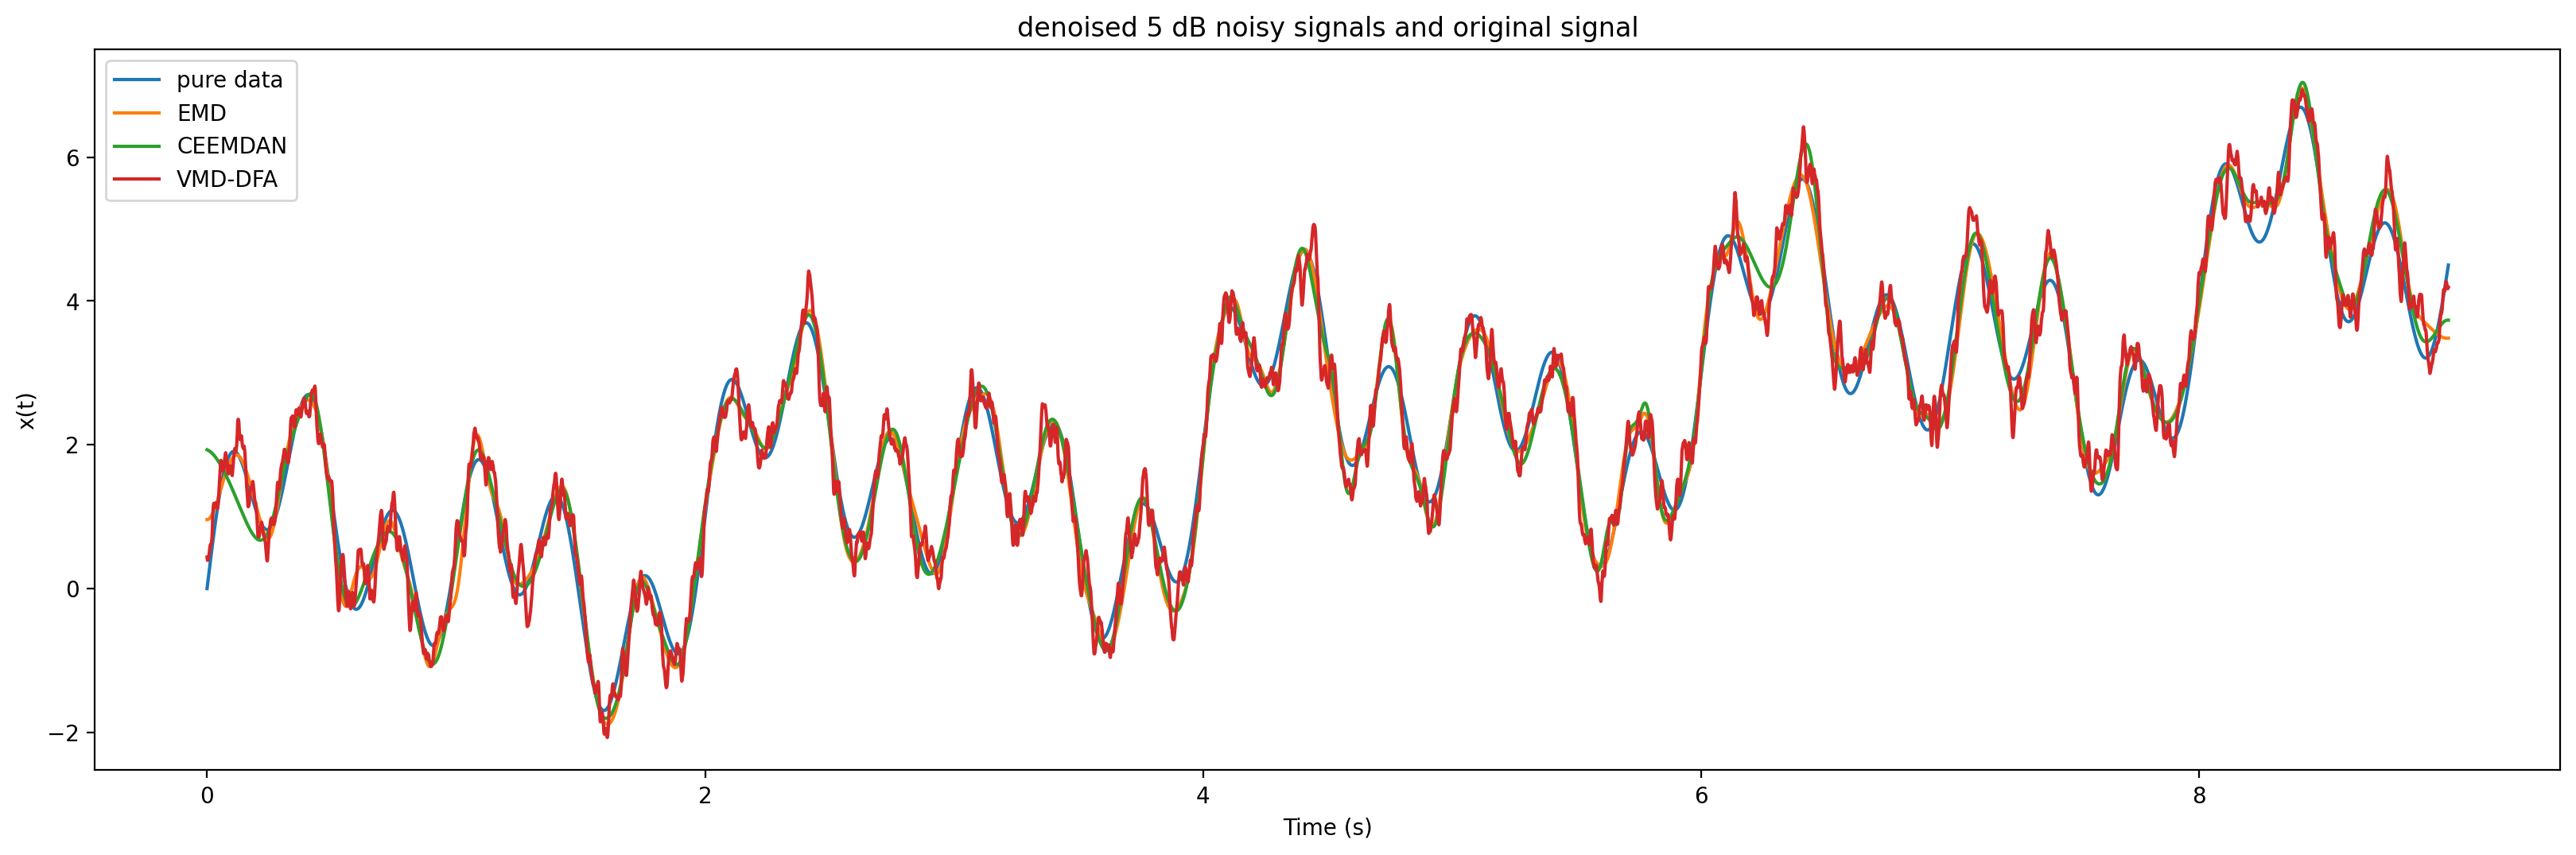

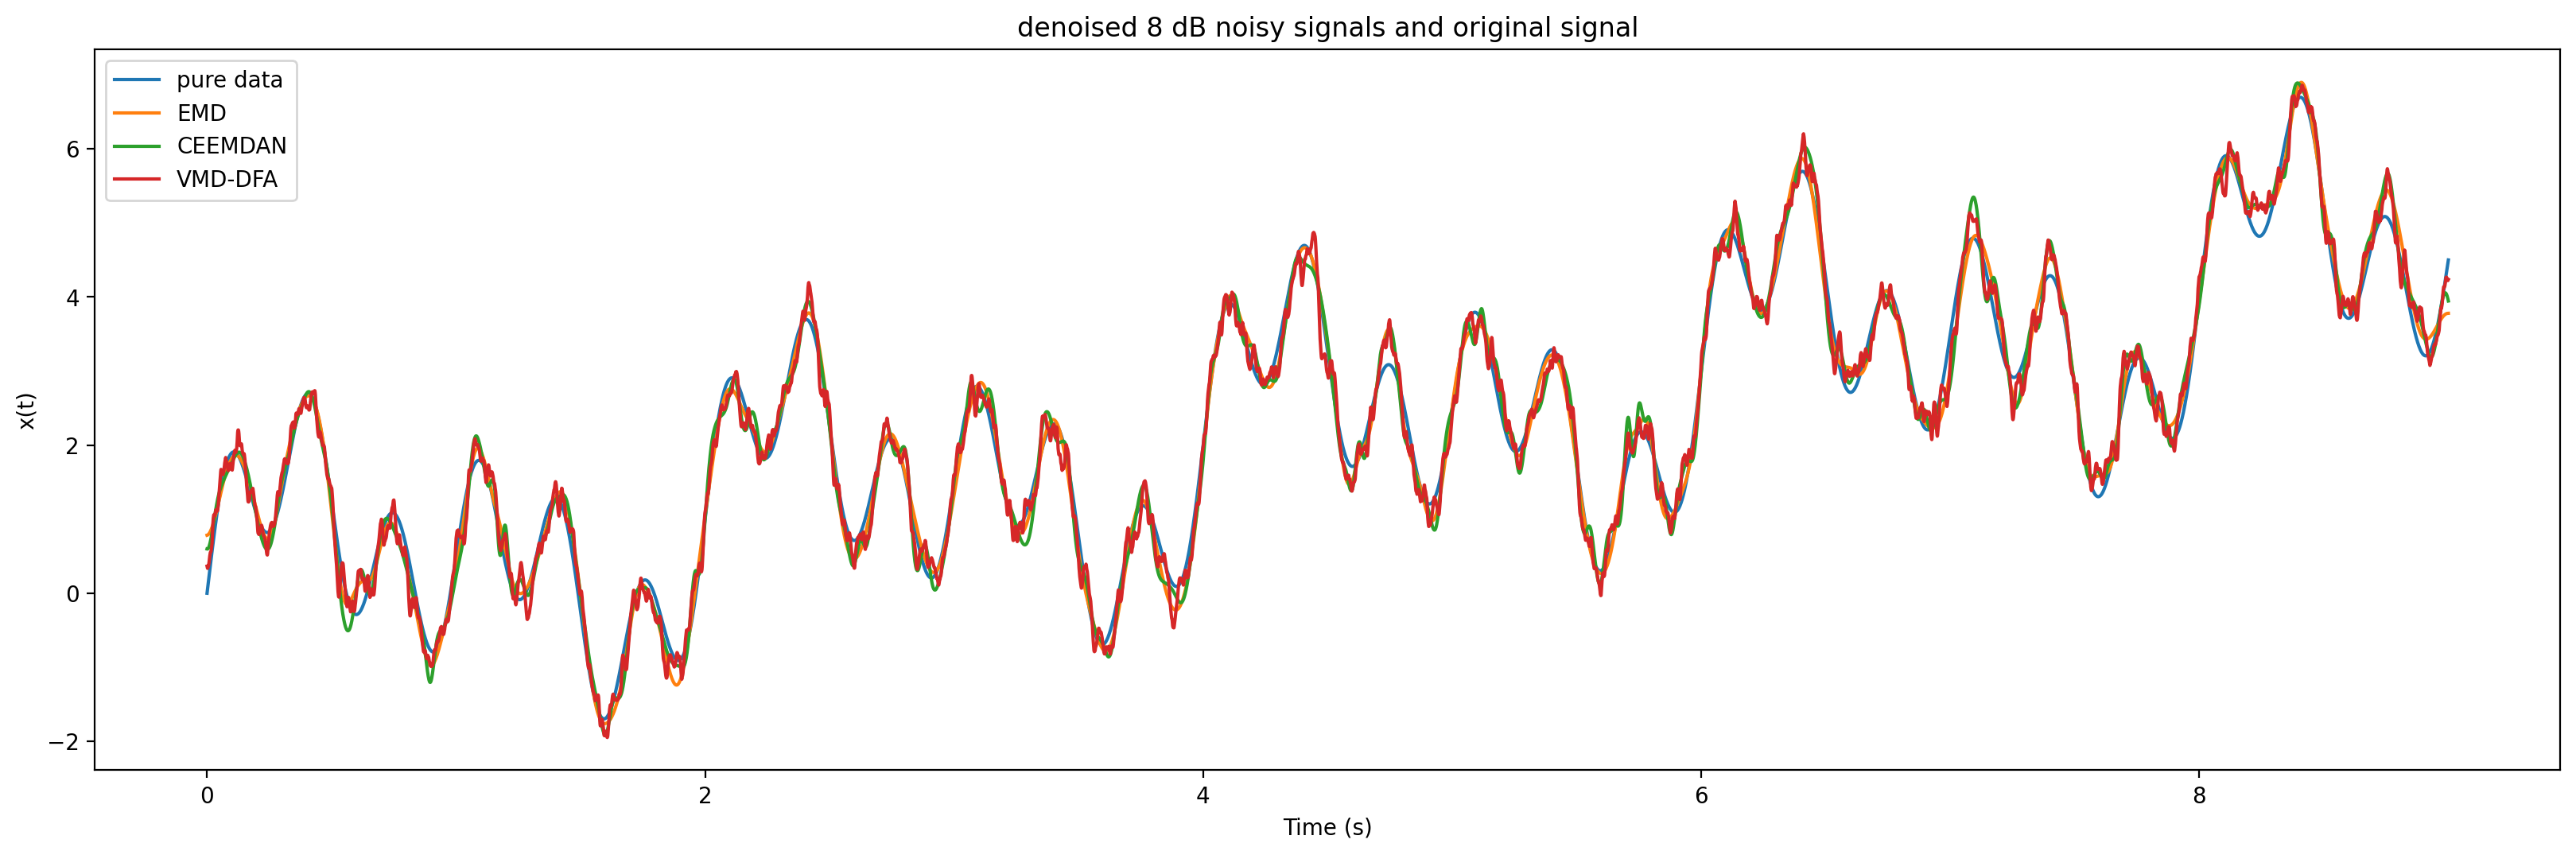

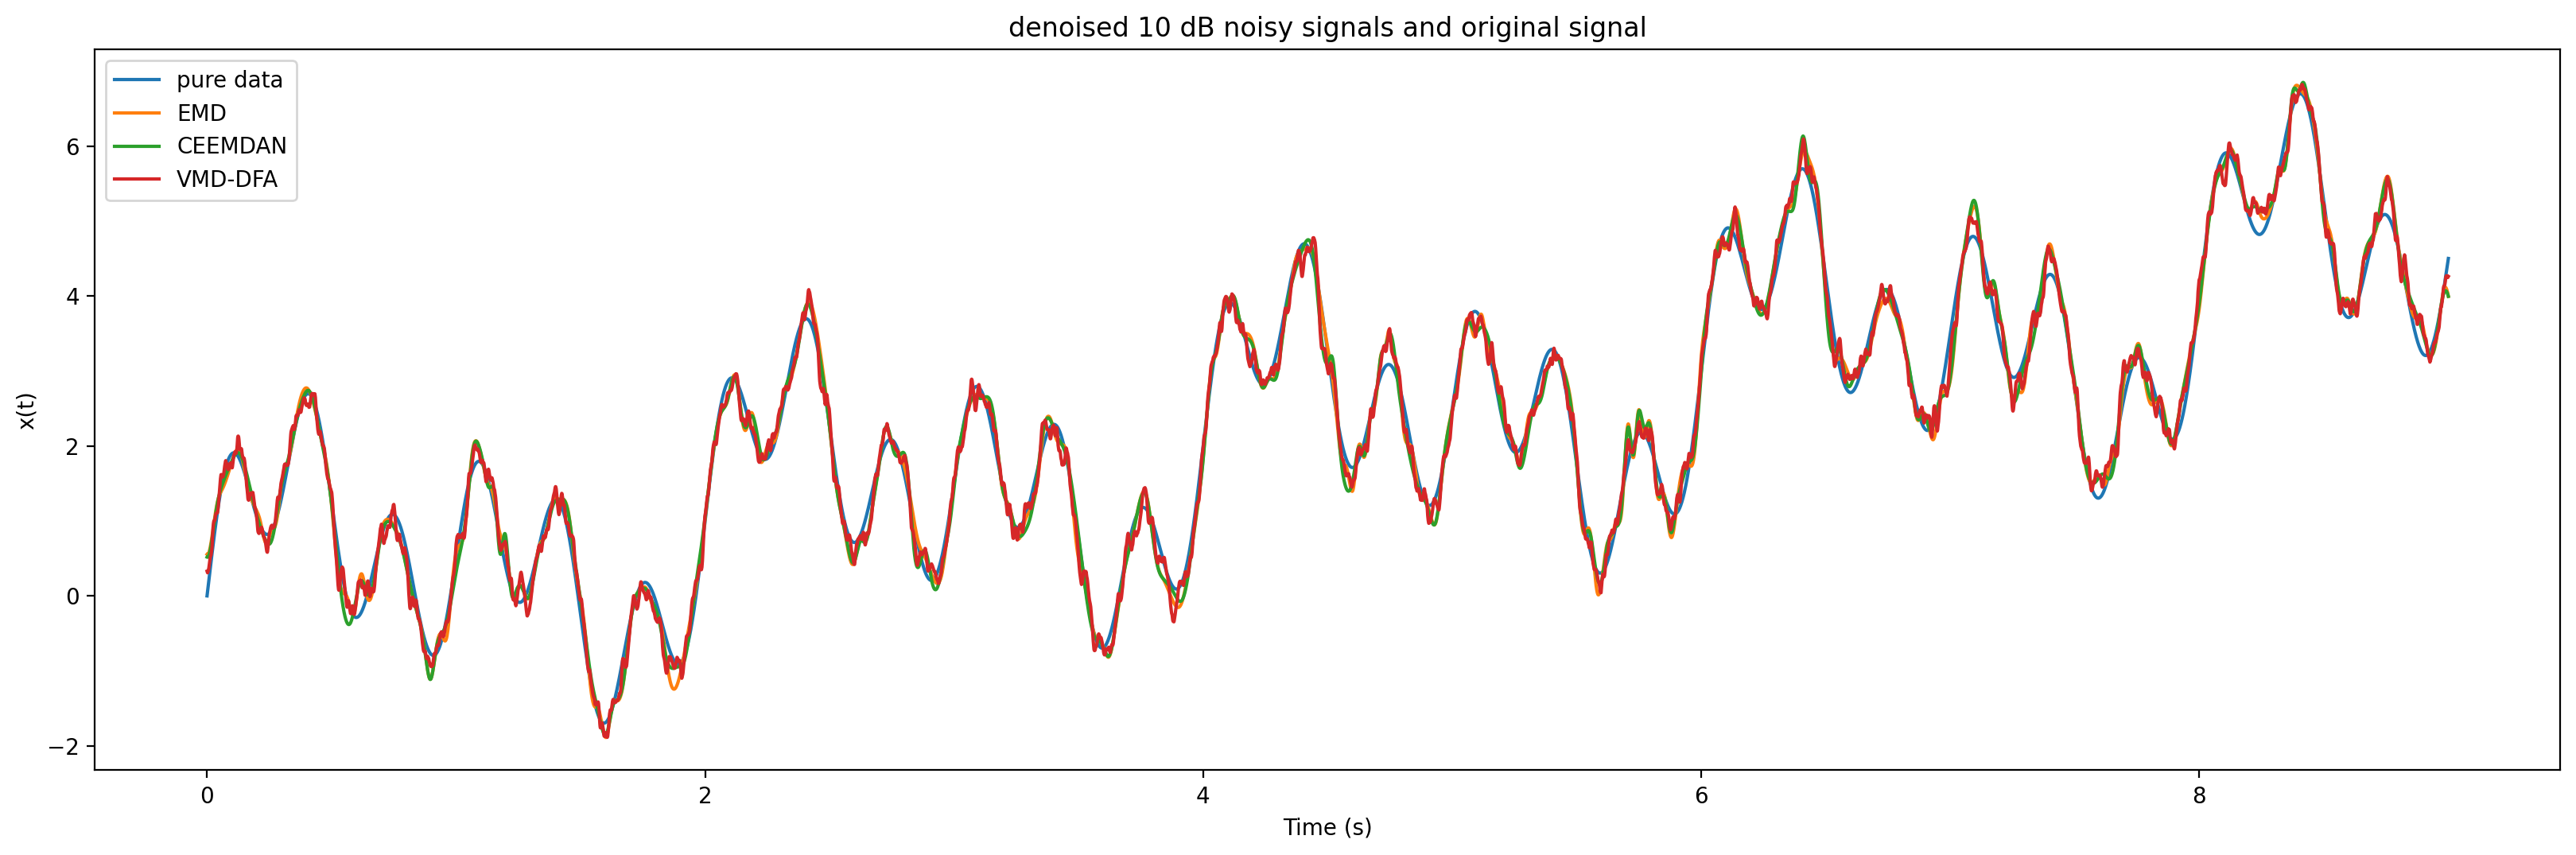

In [101]:
#plot all the denoised signals and the pure signal
for i in range(4):
    plt.figure(figsize=(20,6),dpi=200)
    plt.plot(t, x_volts,label = 'pure data')
    #plt.plot(t, vmd_EMD_nsignal[i],label = 'VMD-EMD-DFA')
    plt.plot(t, emd_nsignal[i],label = 'EMD')
    plt.plot(t, ceemdan_nsignal[i],label = 'CEEMDAN')
    plt.plot(t, vmd_nsignal[i],label = 'VMD-DFA')
    plt.title('denoised '+str(lst[i])+' dB noisy signals and original signal')
    plt.ylabel('x(t)')
    plt.xlabel('Time (s)')
    plt.legend()
    #plt.savefig("./"+'denoised '+str(lst[i])+".jpg")
    plt.show()

# stroe snr and mse

In [56]:
#integration of SNR
snr_df = pd.DataFrame([emd_snr_list,ceemdan_snr_list,vmd_snr_list,vmd_EMD_snr_list])

In [57]:
snr_df = snr_df.T

In [58]:
snr_df.columns = ['EMD','CEEMDAN','VMD-DFA','VMD-EMD-DFA']

In [59]:
snr_df

,EMD,CEEMDAN,VMD-DFA,VMD-EMD-DFA
0,18.124292,18.127836,15.892434,9.987242
1,21.686777,21.273019,19.799117,13.668137
2,24.788559,22.555694,22.754384,16.547693
3,24.338655,24.332550,24.729285,18.429259


In [96]:
snr_df.to_csv('./snr_df.csv')

In [75]:
#integration of MSE
mse_df = pd.DataFrame([emd_mse_list,ceemdan_mse_list,vmd_mse_list,vmd_EMD_mse_list])

In [76]:
mse_df = mse_df.T

In [77]:
mse_df.columns = ['EMD','CEEMDAN','VMD-DFA','VMD-EMD-DFA']

In [78]:
mse_df

,EMD,CEEMDAN,VMD-DFA,VMD-EMD-DFA
0,0.134288,0.134490,0.227775,0.960693
1,0.057853,0.063755,0.090125,0.382307
2,0.028196,0.047449,0.045124,0.191626
3,0.031289,0.031286,0.028493,0.122896


In [97]:
mse_df.to_csv('./mse_df.csv')